In [1]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using NoisyReach
    using Random
    using Plots
    using Statistics

    Random.seed!(123) # Setting the seed
end

  Activating project at `~/Downloads/sc/NoisyReach.jl`


TaskLocalRNG()

In [2]:
sys = benchmarks[:F1]
const N = 500

const x0 = 1000.0
const u0 = 0.0

const T = 2.5
const hc = 1e-4
const Hc = floor(Int, T / hc)

25000

In [3]:
const Dcₑ = 0.005
const Dcₔ = 0.015
const σₑ  = 0.3
const σₔ  = 0.2
const μ   = 0.

const hd   = 0.02
const Hd = floor(Int, T / hd)

125

In [4]:
sys_c, K_c = synthesize(sys, hc)

x₀ = fill(x0, size(sys.A, 1))
xc, uc = simulate(sys_c, Hc, x₀, K_certain, K_c)
xc[end], uc[end]

([6.22752151393206e-5, -6.655762718179536e-5], [2.349678114200005e-5])

In [5]:
sys_d, K_d = synthesize(sys, hd, Dcₑ)

z₀ = [fill(x0, size(sys.A, 1)); u0]
xds, uds = unzip([simulate(sys_d, Hd, z₀, K_uncertain, K_d, σₑ, μ) for _ in 1:N])
xds = [[xd_i[1:2] for xd_i in xd] for xd in xds]
xds[1][end], uds[1][end]

([0.0004310038400923218, -0.0006310393083460538], [0.000438391233453634])

In [6]:
#rel_dev_trajs = [[(1 .- (xds[i][k] ./ xc[1+(k-1)*floor(Int,hd/hc)])) for k in 1:Hd] for i in 1:N]
dev_trajs = [[(xc[1+(k-1)*floor(Int,hd/hc)] .- xds[i][k]) for k in 1:Hd] for i in 1:N]
dev₁_trajs = [[dev[1] for dev in dev_traj] for dev_traj in dev_trajs]
uds₁ = [[udi[1] for udi in ud] for ud in uds]

mean_mean_dev₁ = mean([mean(abs.(dev₁_traj)) for dev₁_traj in dev₁_trajs])
max_max_dev₁ = maximum([maximum(abs.(dev₁_traj)) for dev₁_traj in dev₁_trajs])

mean_rmse_dev₁ = mean([std(dev₁_traj) for dev₁_traj in dev₁_trajs])
std_rmse_dev₁ = std([std(dev₁_traj) for dev₁_traj in dev₁_trajs])
max_rmse_dev₁ = maximum([std(dev₁_traj) for dev₁_traj in dev₁_trajs])

mean_mean_u₁ = mean([mean(abs.(ud₁)) for ud₁ in uds₁])
std_mean_u₁ = std([mean(abs.(ud₁)) for ud₁ in uds₁])
max_max_u₁ = maximum([maximum(abs.(ud₁)) for ud₁ in uds₁])

println("mean_rmse_dev₁	std_rmse_dev₁	mean_mean_u₁	std_mean_u₁")
println("$mean_rmse_dev₁	$std_rmse_dev₁	$mean_mean_u₁	$std_mean_u₁")

mean_rmse_dev₁	std_rmse_dev₁	mean_mean_u₁	std_mean_u₁
48.26009430359616	16.920461932884322	55.97771510522501	3.8441922516428697


In [7]:
convergences = [first_convergence([0.0, 0.0], xds[i], threshold=1e-2) for i in 1:N]
median(convergences)

86.0

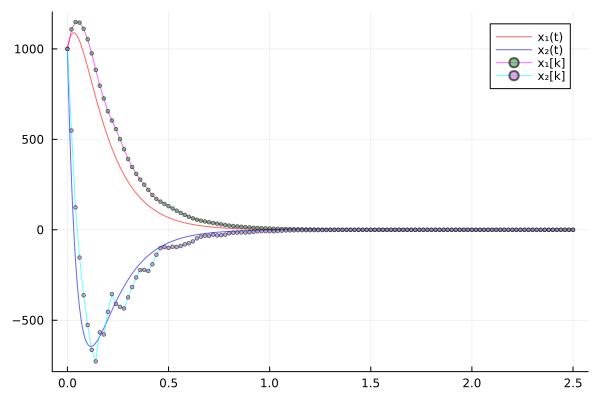

In [8]:
plot_trajectories(xds[8], xc, hd, hc, T)

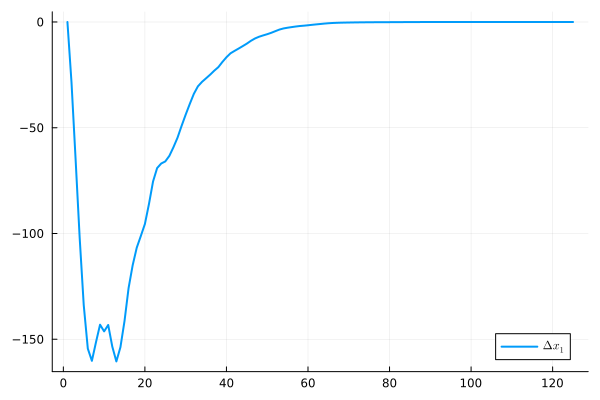

In [9]:
dev₁s = [dev₁ for dev₁ in dev₁_trajs[8]]
plot(1:Hd, dev₁s, label="\$\\Delta x_1\$", lw=2)

In [10]:
#println("Trajectories that failed to converge:\n", [i for i in 1:N if isnothing(first_convergence([0.0, 0.0], xds[i], threshold=1e-2))])

In [11]:
#show(stdout, "text/plain", uds[5])

In [12]:
maximum(xd -> maximum(xd -> abs(xd[1]), xd), xds)

1243.2072352406599

In [13]:
maximum(ud -> maximum(ud -> abs(ud[1]), ud), uds)

2399.3841314562032

In [14]:
maximum(xc -> abs(xc[1]), xc)

1089.0862401887914

In [15]:
maximum(u -> abs(u[1]), uc)

2285.9891619269965